# Statistical Methods for Machine Temperature Anomaly Detection

This notebook applies statistical methods to the NAB machine temperature dataset.  

Covered methods:
- Global: Z-Score, IQR  
- Local: Rolling Z-Score, Rolling IQR  
- Sequential: CUSUM, EWMA  
- Trend: Mann-Kendall  

The performance of each method was evaluated using precision, recall, F1-score, coverage, and early detection rate, supported by visualizations to illustrate how detections align with failure windows.

## Setup

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pathlib

repo_root = pathlib.Path.cwd().resolve().parents[1]  
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# utils from this repo
from utils.config import DEFAULTS
from utils.data_loader import load_dataset 
from utils.detectors_stats import run_detectors
from utils.visualizations import (
    plot_methods_subplots
)
from utils.evaluation import evaluate_predictions

def adapt_config(defaults):
    cfg = {"global":{}, "local":{}, "sequential":{}, "trend":{}, "forecast":{}}
    for section, sub in defaults.items():
        if section not in cfg:
            continue
        for key, opts in sub.items():
            if isinstance(opts, dict) and "enabled" in opts:
                if opts["enabled"]:
                    cfg[section][key] = {k:v for k,v in opts.items() if k != "enabled"}
    return cfg

config = adapt_config(DEFAULTS)

## Load Dataset

In [28]:
df, windows = load_dataset("machine_temperature")


## Apply Statistical Detectors

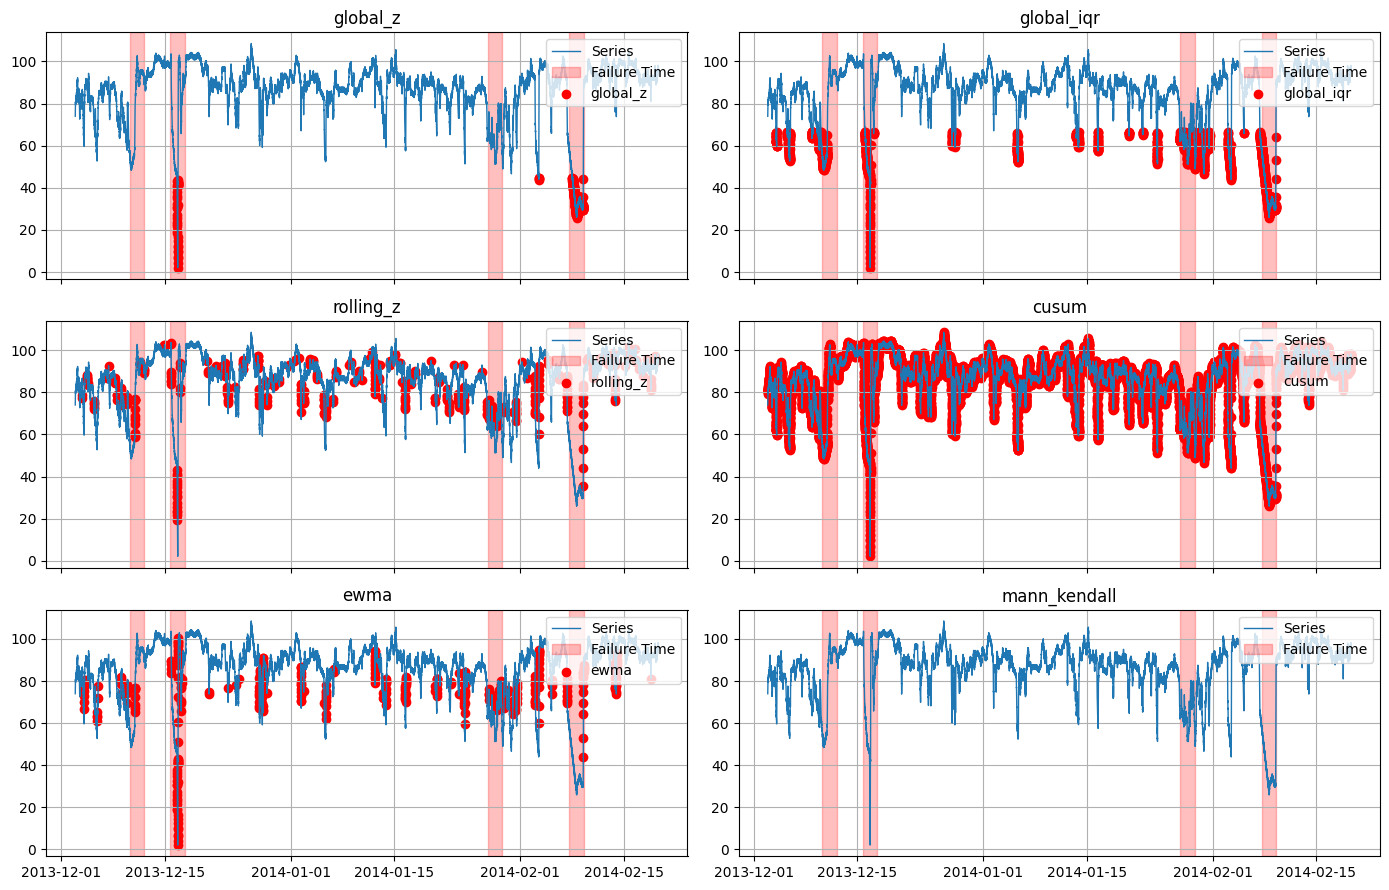

In [29]:
results = run_detectors(df, "value", config)
methods_preds = {name: res["mask"].astype(int) if "mask" in res else None
                 for name,res in results["per_method"].items()}
plot_methods_subplots(df, methods_preds, value_col="value", windows=windows)

## Evaluate Detectors

In [30]:
eval_results = {}
for name, res in results["per_method"].items():
    if "mask" in res:
        eval_results[name] = evaluate_predictions(df, res["mask"], windows, early_tolerance="1h")
eval_results["combined"] = evaluate_predictions(df, results["combined_mask"], windows, early_tolerance="1h")

pd.DataFrame(eval_results).T.round(3)

,tp,fp,fn,tn,precision,recall,f1,coverage,early_detection_rate
global_z,458.0,4.0,1810.0,20423.0,0.991,0.202,0.336,0.5,0.0
global_iqr,1333.0,965.0,935.0,19462.0,0.580,0.588,0.584,1.0,0.0
rolling_z,73.0,350.0,2195.0,20077.0,0.173,0.032,0.054,1.0,0.0
cusum,2268.0,20417.0,0.0,10.0,0.100,1.000,0.182,1.0,0.0
ewma,101.0,262.0,2167.0,20165.0,0.278,0.045,0.077,1.0,0.0
combined,2268.0,20417.0,0.0,10.0,0.100,1.000,0.182,1.0,0.0


### Performance Summary
**IQR** and **MAD** achieved the most reliable results, offering a strong balance between precision and recall. Their robustness to noise and sensitivity to sharp deviations make them well-suited for this dataset, where anomalies tend to appear as sudden spikes rather than gradual drifts.

**Z-Score** achieved very high precision but suffered from low recall, meaning it only flagged the most extreme anomalies and missed subtler ones. Lowering the threshold could improve sensitivity, though it may reduce precision.

**CUSUM** produced many false positives, resulting in low precision. This method is designed for detecting sustained shifts, it does not perform well in noisy environments and often misses sudden spikes.

**Percent Change** showed moderate precision but low recall, suggesting it failed to detect many actual anomalies. Reducing the percentage threshold could improve coverage but risks increasing false alarms. 

**Rolling Mean** performed the weakest overall. The selected window size and threshold likely didn’t align with the anomaly patterns in the data, causing poor detection. This method may benefit from refined parameters or from being used in combination with other techniques.

Overall, **IQR** and **MAD** are the most reliable methods in this setting. They require minimal tuning, handle noise effectively, and are particularly good at identifying isolated outliers in relativelty stable signals.